In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.append("../../")
from src.config.paths import RAW_DIR, PROCESSED_DIR



In [15]:
# Step 1: Detecting "Stealth" Large Trades Without Order Book Data
def load_data(ticker: str):
    df = pd.read_csv(RAW_DIR / f'{ticker}_1min.csv')
    required_columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Column {col} not found in {ticker}_1min.csv")
        
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['daily_volatility'] = df['close'].rolling(window=21).std()
    df['daily_volatility'] = df['daily_volatility'].replace([np.inf, -np.inf], np.nan)
    df['daily_volatility'] = df['daily_volatility'].fillna(0)
    df['log_returns'] = df['log_returns'].replace([np.inf, -np.inf], np.nan)
    df['log_returns'] = df['log_returns'].fillna(0)


    return df

def calculate_vwpp(df):
    """
    Calculate Volume-Weighted Price Pressure (VWPP) to detect institutional trading footprints.
    
    High VWPP indicates aggressive large traders
    Low VWPP suggests passive institutional orders being absorbed
    
    Parameters:
        df (pd.DataFrame): DataFrame with price and volume data
        
    Returns:
        pd.Series: VWPP values
    """
    # Calculate price changes
    price_changes = df['close'].diff()
    
    # Calculate VWPP
    vwpp = price_changes / df['volume']
    
    # Replace inf/nan from zero volume with 0
    vwpp = vwpp.replace([np.inf, -np.inf], np.nan)
    vwpp = vwpp.fillna(0)
    
    return vwpp

# Load sample data
df = load_data("AAPL")

# Calculate VWPP
df['vwpp'] = calculate_vwpp(df)

# Add labels for institutional trading patterns
df['institutional_footprint'] = pd.cut(
    df['vwpp'],
    bins=[-np.inf, -0.001, 0.001, np.inf],
    labels=['Aggressive Selling', 'Passive Trading', 'Aggressive Buying']
)

print("VWPP Statistics:")
print(df['vwpp'].describe())
print("\nInstitutional Footprint Distribution:")
print(df['institutional_footprint'].value_counts(normalize=True))





VWPP Statistics:
count    458945.000000
mean          0.000018
std           0.004491
min          -0.855737
25%          -0.000003
50%           0.000000
75%           0.000003
max           0.881136
Name: vwpp, dtype: float64

Institutional Footprint Distribution:
institutional_footprint
Passive Trading       0.955178
Aggressive Buying     0.022791
Aggressive Selling    0.022031
Name: proportion, dtype: float64



Volume Surprise Statistics:
count    458945.000000
mean          1.048290
std           1.950504
min           0.000013
25%           0.248552
50%           0.714469
75%           1.157963
max          29.968611
Name: volume_surprise, dtype: float64

Volume Pattern Distribution:
volume_pattern
Normal                 0.475166
Below Normal           0.371807
Institutional Burst    0.153027
Name: proportion, dtype: float64


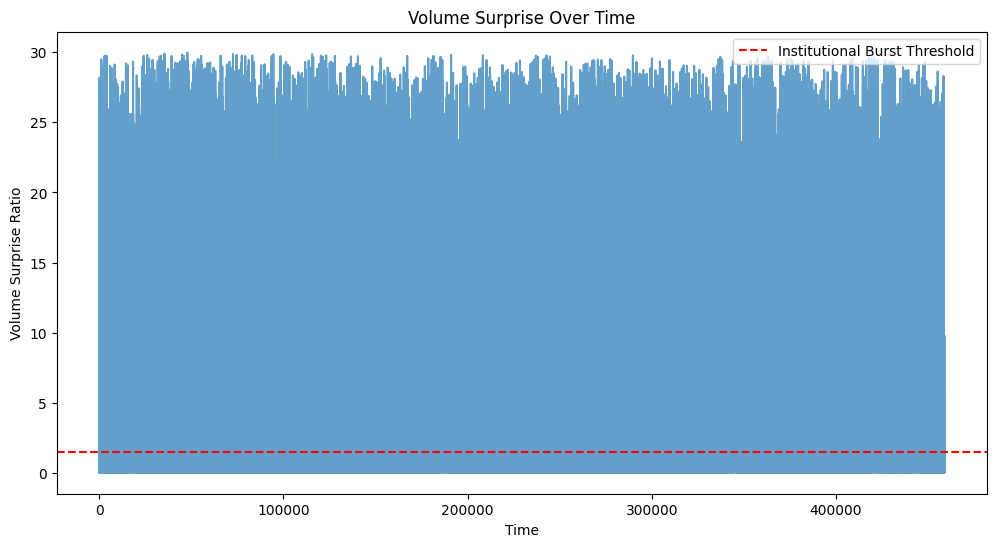

In [9]:
def calculate_volume_surprise(df, window=30):
    """
    Calculate volume surprise by comparing current volume to expected volume pattern.
    
    Higher values indicate sudden order bursts likely from institutional trading.
    
    Parameters:
        df (pd.DataFrame): DataFrame with volume data
        window (int): Rolling window size for expected volume calculation
        
    Returns:
        pd.Series: Volume surprise values
    """
    # Calculate expected volume using rolling mean
    expected_volume = df['volume'].rolling(window=window).mean()
    
    # Calculate volume surprise ratio
    volume_surprise = df['volume'] / expected_volume
    
    # Replace inf/nan values
    volume_surprise = volume_surprise.replace([np.inf, -np.inf], np.nan)
    volume_surprise = volume_surprise.fillna(1.0)  # Default to normal volume
    
    return volume_surprise

# Calculate volume surprise
df['volume_surprise'] = calculate_volume_surprise(df)

# Add labels for volume surprise levels
df['volume_pattern'] = pd.cut(
    df['volume_surprise'],
    bins=[0, 0.5, 1.5, np.inf],
    labels=['Below Normal', 'Normal', 'Institutional Burst']
)

print("\nVolume Surprise Statistics:")
print(df['volume_surprise'].describe())
print("\nVolume Pattern Distribution:")
print(df['volume_pattern'].value_counts(normalize=True))

# Plot volume surprise over time
plt.figure(figsize=(12,6))
plt.plot(df.index, df['volume_surprise'], alpha=0.7)
plt.axhline(y=1.5, color='r', linestyle='--', label='Institutional Burst Threshold')
plt.title('Volume Surprise Over Time')
plt.xlabel('Time')
plt.ylabel('Volume Surprise Ratio') 
plt.legend()
plt.show()



Volume Entropy Statistics:
count    458936.000000
mean          0.829233
std           0.189932
min           0.000000
25%           0.753469
50%           0.886974
75%           0.976510
max           1.000000
Name: volume_entropy, dtype: float64

Volume Clustering Distribution:
volume_clustering
Low Clustering         0.844649
Moderate Clustering    0.122584
High Clustering        0.032767
Name: proportion, dtype: float64


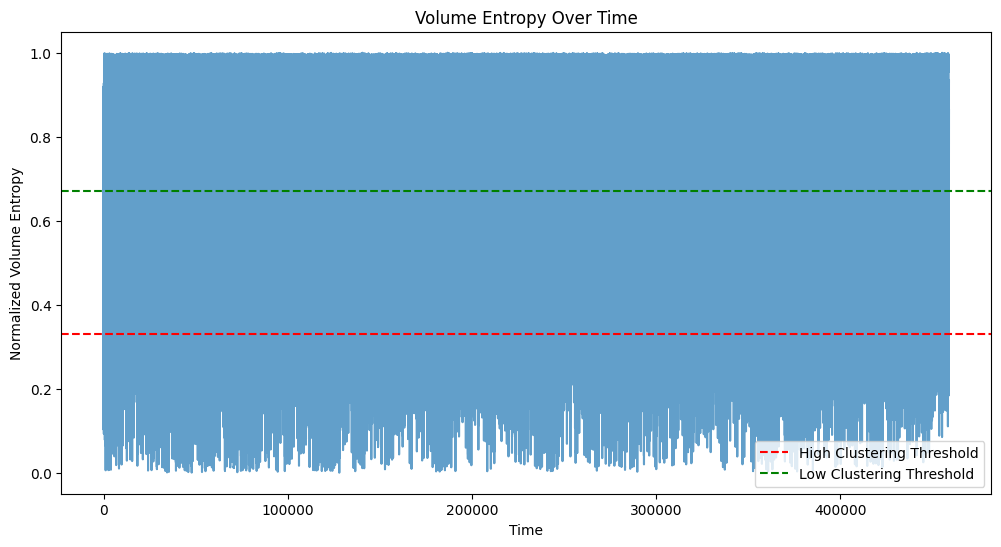

In [11]:
def calculate_volume_entropy(df, window=10):
    """
    Calculate rolling entropy of volume distribution to detect clustering.
    
    Parameters:
        df (pd.DataFrame): DataFrame with volume data
        window (int): Window size for entropy calculation
        
    Returns:
        pd.Series: Volume entropy values
    """
    def entropy(x):
        # Normalize volumes to probabilities
        probs = x / x.sum()
        # Remove zeros to avoid log(0)
        probs = probs[probs > 0]
        # Calculate entropy
        return -np.sum(probs * np.log(probs))
    
    # Calculate rolling entropy
    volume_entropy = df['volume'].rolling(window=window).apply(entropy)
    
    # Normalize to [0,1] range
    volume_entropy = (volume_entropy - volume_entropy.min()) / (volume_entropy.max() - volume_entropy.min())
    
    return volume_entropy

# Calculate volume entropy
df['volume_entropy'] = calculate_volume_entropy(df)

# Add labels for volume clustering
df['volume_clustering'] = pd.cut(
    df['volume_entropy'],
    bins=[0, 0.33, 0.67, 1],
    labels=['High Clustering', 'Moderate Clustering', 'Low Clustering']
)

print("\nVolume Entropy Statistics:")
print(df['volume_entropy'].describe())
print("\nVolume Clustering Distribution:")
print(df['volume_clustering'].value_counts(normalize=True))

# Plot volume entropy over time
plt.figure(figsize=(12,6))
plt.plot(df.index, df['volume_entropy'], alpha=0.7)
plt.axhline(y=0.33, color='r', linestyle='--', label='High Clustering Threshold')
plt.axhline(y=0.67, color='g', linestyle='--', label='Low Clustering Threshold')
plt.title('Volume Entropy Over Time')
plt.xlabel('Time')
plt.ylabel('Normalized Volume Entropy')
plt.legend()
plt.show()


In [16]:
df

,timestamp,open,high,low,close,volume,log_returns,daily_volatility,vwpp,institutional_footprint
0,2025-02-14 19:59:00,244.6500,244.6500,244.5000,244.6400,794,0.000000,0.000000,0.000000,Passive Trading
1,2025-02-14 19:58:00,244.7000,244.7500,244.6500,244.6500,1003,0.000041,0.000000,0.000010,Passive Trading
2,2025-02-14 19:57:00,244.7000,244.7500,244.6800,244.7000,35,0.000204,0.000000,0.001429,Aggressive Buying
3,2025-02-14 19:56:00,244.7500,244.7500,244.6700,244.6700,245,-0.000123,0.000000,-0.000122,Passive Trading
4,2025-02-14 19:55:00,244.7100,244.7400,244.7000,244.7300,19,0.000245,0.000000,0.003158,Aggressive Buying
...,...,...,...,...,...,...,...,...,...,...
458940,2023-03-01 04:04:00,146.7540,146.8431,146.7243,146.8233,2949,0.000337,0.111324,0.000017,Passive Trading
458941,2023-03-01 04:03:00,146.8233,146.8233,146.8035,146.8233,1061,0.000000,0.117284,0.000000,Passive Trading
458942,2023-03-01 04:02:00,146.7243,146.8233,146.7243,146.8233,1049,0.000000,0.119546,0.000000,Passive Trading
458943,2023-03-01 04:01:00,146.8035,146.8233,146.6550,146.8233,1318,0.000000,0.119018,0.000000,Passive Trading
